In [1]:

import tensorflow as tf
import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# #define the model
model = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3, padding="same", activation="relu", input_shape=[32,32,3]),
    keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5,noise_shape=None,seed=None),
    keras.layers.Dense(units= 128,activation="relu"),
    keras.layers.Dense(units=10,activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [3]:
# # compile the keras model
model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])


In [4]:
#Extract the cifar10 images and labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

img_rows, img_cols, channels = 32, 32, 3
num_classes = 10

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255


print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)


Data shapes (10000, 32, 32, 3) (10000, 1) (50000, 32, 32, 3) (50000, 1)


In [5]:
# fit the keras model on the dataset
model.fit(x_train, y_train,epochs=5)

# evaluate the keras model
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
# evaluate the keras model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTrain accuracy:', train_acc)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1563/1563 [==============================] - 146s 93ms/step - sparse_categorical_accuracy: 0.4925 - loss: 1.4028
Epoch 2/5
1563/1563 [==============================] - 128s 82ms/step - sparse_categorical_accuracy: 0.6449 - loss: 0.9989
Epoch 3/5
1563/1563 [==============================] - 128s 82ms/step - sparse_categorical_accuracy: 0.7011 - loss: 0.8520
Epoch 4/5
1563/1563 [==============================] - 139s 89ms/step - sparse_categorical_accuracy: 0.7333 - loss: 0.7599
Epoch 5/5
1563/1563 [==============================] - 143s 91ms/step - sparse_categorical_accuracy: 0.7577 - loss: 0.6851
1563/1563 - 34s - sparse_categorical_accuracy: 0.8266 - loss: 0.5056
313/313 - 7s - sparse_categorical_accuracy: 0.7622 - loss: 0.6959

Train accuracy: 0.8265600204467773

Test accuracy: 0.7621999979019165


In [6]:

test_predictions = model.predict(x_test)
train_predictions = model.predict(x_train)

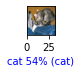

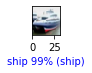

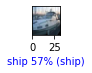

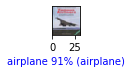

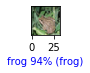

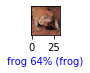

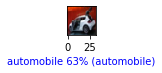

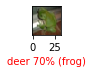

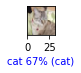

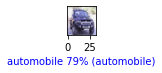

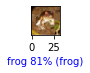

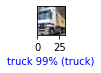

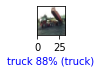

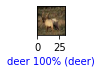

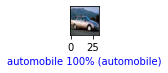

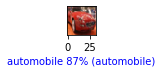

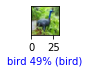

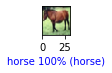

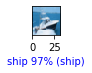

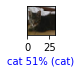

In [30]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


def display_images(images, predicted_labels, true_labels):
    '''
    Display the images in an orderly way that associates it with its predicted and true labels.
    :images: the input images
    :predicted_labels: the predicted labels from the model
    :true_labels: the correct labels
    '''
    n = 10  # How many digits we will display
    plt.figure()
    for i in range(n):
      # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_yaxis().set_visible(False)

        predicted_label = np.argmax(predicted_labels[i])

        if predicted_label == true_labels[i].item():
            color = 'blue'
        else:
            color = 'red'
        

        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predicted_labels[i]),
                                        class_names[true_labels[i].item()]),
                                        color=color)


        plt.show()
display_images(x_test, test_predictions, y_test)
display_images(x_train, train_predictions, y_train)

Now, create an FGSM adversarial attack function that perturbs the data using the formula
$$\text{Untargeted: }x' = x + \epsilon.sign(\nabla_xl(x,y))$$

In [8]:
#Define the categorical cross-entropy loss object
loss_object = keras.losses.CategoricalCrossentropy(from_logits=True )

def single_adversarial_attack(input_image, input_label, eps):
    '''
    Produce a single-step adversarial attack on a single image
    :input_image: the image being attacked
    :input_label: the correct label for the image
    :eps: a hyperparameter
    '''
    #Recast the image as a tensor of the proper size and datatype
    input_image = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)

        #Get the predicted output of the i
        prediction = tf.transpose(model(input_image))
        input_label = input_label.reshape((input_label.shape[0],1))
        #Get the loss between the true and predicted label
        loss = loss_object(input_label, prediction)

        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_image)

        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)


        output = input_image + signed_grad*eps


    return tf.reshape(output,(img_rows, img_cols, channels))

In [9]:
def adversarial_attack(images, labels, eps):
    '''
    Perform a single-step adversarial attack on an entire dataset
    :images: the input images
    :labels: the true labels for the inputs
    :eps: a hyperparameter
    '''
    adv_images = []
    for x, y in zip(images, labels):
        adv_images.append(single_adversarial_attack(x,y,eps).numpy())

    return np.asarray(adv_images)

In [10]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
image = x_train[0]
label = y_train_categorical[0].reshape(y_train_categorical[0].shape[0],1)
x_adv = single_adversarial_attack(image, label, 0.1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


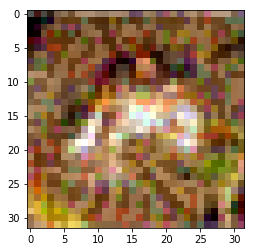

In [12]:
plt.imshow(x_adv)
plt.show()

In [13]:
#Create an attack on the training data
attack_imgs = adversarial_attack(x_train, y_train_categorical, 0.1)


In [14]:
print("Base accuracy on adversarial images:", model.evaluate(x=attack_imgs, y=y_train, verbose=0))

Base accuracy on adversarial images: [6.639591217041016, 0.04546000063419342]


In [15]:
adv_train_predictions = model.predict(attack_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


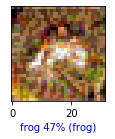

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


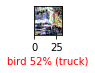

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


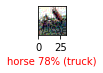

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


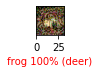

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


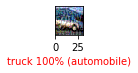

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


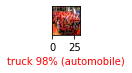

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


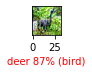

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


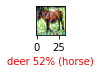

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


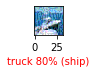

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


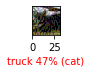

In [16]:
display_images(attack_imgs, adv_train_predictions, y_train)

Now implement a multi-step untargeted PGD adversarial attack using the formula:
$$\text{Untargeted: }x_0' = x \implies x_{N+1}' = Clip_{x,\epsilon}\{x_N' + \alpha.sign(\nabla_xl(x_n', y)\} $$

In [23]:


def single_multistep_adversarial_attack(input_image, input_label, eps, a, T):
    '''
    Produce a multi-step adversarial attack on a single image
    :input_image: the image being attacked
    :input_label: the correct label for the image
    :eps: a hyperparameter
    :a: another hyperparameter defining the step size
    :T: the number of steps to be taken
    '''

    image_temp = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)


    for t in range(T):
    #Define the step size
        step_size = (1 - a*t)**(-1)

        with tf.GradientTape() as tape:
            tape.watch(image_temp)

            #Predict the label of the image
            prediction = tf.transpose(model(image_temp))
            input_label = input_label.reshape((input_label.shape[0],1))
            #Calculate the loss between the true label and the prediction
            loss = loss_object(input_label, prediction)

            # Get the gradients of the loss w.r.t to the input image.
            gradient = tape.gradient(loss, image_temp)

            # Get the sign of the gradients to create the perturbation
            signed_grad = tf.sign(gradient)

            image_temp = image_temp + signed_grad*step_size


    return tf.reshape(image_temp, [img_rows, img_cols, channels])

In [24]:
def multistep_adversarial_attack(images, labels, eps, a, T):
    '''
    Perform multi-step adversarial attacks on an entire dataset
    :images: the images being attacked
    :labels: the correct labels for the images
    :eps: a hyperparameter
    :a: another hyperparameter defining the step size
    :T: the number of steps to be taken
    '''
    adv_images = []
    for i, (x, y) in enumerate(zip(images, labels)):
        adv_images.append(single_multistep_adversarial_attack(x,y,eps, a, T).numpy())

    return np.asarray(adv_images)

In [25]:
multistep_attack = single_multistep_adversarial_attack(x_train[0], y_train_categorical[0], 0.1, 0.01, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


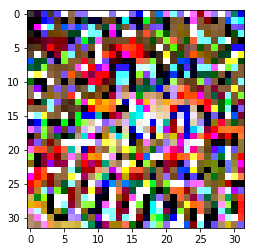

In [26]:
plt.imshow(multistep_attack)
plt.show()

In [27]:
multistep_attack_images = multistep_adversarial_attack(x_train[0:300], y_train_categorical[0:300], 0.1, 0.001, 100)

In [28]:
print("Base accuracy on adversarial images:", model.evaluate(x=multistep_attack_images, y=y_train[0:300], verbose=0))
adv_train_predictions = model.predict(multistep_attack_images)

Base accuracy on adversarial images: [149.12445068359375, 0.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


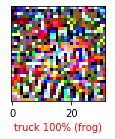

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


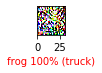

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


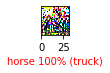

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


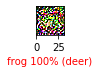

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


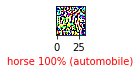

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


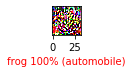

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


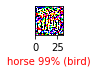

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


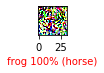

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


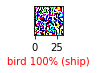

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


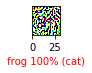

In [29]:
display_images(multistep_attack_images, adv_train_predictions, y_train[0:300])